In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
sns.set(style = "whitegrid",font_scale=1.4)


In [2]:
data_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/processed_data')
out_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/external_selfResp_combined')
fig_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/figures')
filename_county = 'externalMeasures_county.csv'
filename_state = 'externalMeasures_state.csv'


county_data = pd.read_csv(os.path.join(data_dir, filename_county))
county_data['state_county'] = county_data['state'] +'_' +county_data['county']
county_data = county_data.loc[~(county_data['county'].isna()) & ~(county_data['state'].isna()),:]
county_data = county_data = county_data.loc[county_data.wave_day == 'start_date']

wave_to_week = pd.read_csv(os.path.join(data_dir, 'wave_to_week.csv'))
county_data = county_data.merge(wave_to_week[['wave', 'wave_week']], on='wave', how = 'left')
county_data = county_data.rename(columns={'wave_week': 'week'})
county_data.loc[county_data.gatherBan_N_limit == 'No ban', 'gatherBan_N_limit'] = np.nan
county_data.gatherBan_N_limit = county_data.gatherBan_N_limit.astype('float')


state_data = pd.read_csv(os.path.join(data_dir, filename_state))
state_data = state_data.rename(columns = {'date': 'Date'})
state_data = state_data.drop(['year', 'month', 'day'], axis = 1)
state_data['Date'] = pd.to_datetime(state_data['Date'])
wave_to_week['Date'] = pd.to_datetime(wave_to_week['Date'])
state_data = state_data.merge(wave_to_week[['wave_week', 'wave', 'Date']], on = 'Date')

national_data = state_data[['cases_avg_per_100k','ueRate', 'restriction_sum',
       'wave_week', 'wave']].groupby(by=['wave','wave_week']).mean().reset_index()
national_data = national_data.rename(columns = {'cases_avg_per_100k': 'cases_avg_per_100k_nat',
                                                'ueRate': 'ueRate_nat',
                                                'restriction_sum': 'restriction_sum_nat',
                                                'wave_week': 'week'})


# process restriction data

In [3]:
county_data_anonymous = county_data.drop(['PROLIFIC_PID', 'loc_description', 'flag'], axis=1)

county_data_anonymous = county_data_anonymous.loc[county_data_anonymous.wave_day == 'start_date', :]
county_data_anonymous = county_data_anonymous.drop_duplicates().reset_index(drop = True)
county_data_anonymous

missing_restriction = county_data_anonymous[['wave', 
             'state_county',
             'stayAtHomeOrder',
             'gatherBan',
             'bar_restriction',
             'restaurant_restriction']].pivot(index = 'state_county',
                                       columns = 'wave', 
                                       values=['stayAtHomeOrder', 
                                               'restaurant_restriction',
                                               'bar_restriction', 
                                               'gatherBan']).isnull().all(1)
county_missing_restriction = list(missing_restriction[missing_restriction == True].index)

missing_covid_cases = county_data_anonymous[['wave', 
             'state_county',
             'cases_avg_per_100k']].pivot(index = 'state_county',
                                       columns = 'wave', 
                                       values=['cases_avg_per_100k']).isnull().all(1)
county_missing_covid_cases = list(missing_covid_cases[missing_covid_cases == True].index)


# drop counties lacking all any data 
county_data = county_data.loc[~county_data.state_county.isin(county_missing_restriction),:].copy()
county_data.fillna({'stayAtHomeOrder':0, 
                          'restaurant_restriction':0,
                         'bar_restriction':0,
                         'gatherBan':0}, inplace=True)
county_data['restriction_sum'] = county_data['stayAtHomeOrder'] + county_data['gatherBan'] + county_data['bar_restriction'] + county_data['restaurant_restriction']

# drop counties missing covid cases
county_data = county_data.loc[~county_data.state_county.isin(county_missing_covid_cases),:].copy()
county_data.to_csv(os.path.join(out_dir, 'externalMeasures_withRestrictionSum_county.csv'),index = False)

# drop W18
county_data = county_data.loc[county_data.wave<18,:]

# Maximum Variation Sampling

In [4]:
###########################################################################################################################
# code from Yanting Han: https://github.com/adolphslab/CovidDynamic_dataRelease/blob/main/figures-tables/TempTrends_ExmplVars%20/IDforplot.py
# Farthest point sampling
def calc_distances(p0, points):
    return np.sqrt(((p0 - points)**2.).sum(axis=1))

def farthest_points(pts, pt_labels, K,ii):
    ndims = pts.shape[1] #5 dims
    farthest_pts = np.zeros((K, ndims)) # specify format for wanted points, 5/10 people*5 dim
    farthest_pts[0] = pts[ii]  
    farthest_pts_labs = []
    farthest_pts_labs.append(pt_labels[ii]) # append label 
    distances = calc_distances(farthest_pts[0], pts) # calculate dist for this subject with all other ones

    for ij in range(1, K):
        farthest_pts[ij] = pts[np.argmax(distances)] #returns the index of the subject with the furthest dist
        farthest_pts_labs.append(pt_labels[np.argmax(distances)])
        distances = np.minimum(distances, calc_distances(farthest_pts[ij], pts))
        # for the rest of the points, update the distance to be the min to the already chosen ones
    return farthest_pts, farthest_pts_labs

# maximum variation sampling (eucl.-dist)
def max_var_sampling(value_array, id_lables, K):
    all_sols_dists = []
    all_sols_feats = []
    all_sols_names = []
    for iter_ii in range(value_array.shape[0]):
        solution_set, solution_labels = farthest_points(value_array,id_lables,K, iter_ii)
        all_sols_feats.append(solution_set)
        all_sols_names.append(solution_labels)
        all_sols_dists.append(np.sum(pdist(solution_set, metric='euclidean')))

    best_sols_feats = all_sols_feats[np.argmax(all_sols_dists)]
    best_sols_labels = all_sols_names[np.argmax(all_sols_dists)]
    return best_sols_feats, best_sols_labels
###########################################################################################################################

# visualize maximally different timecourses

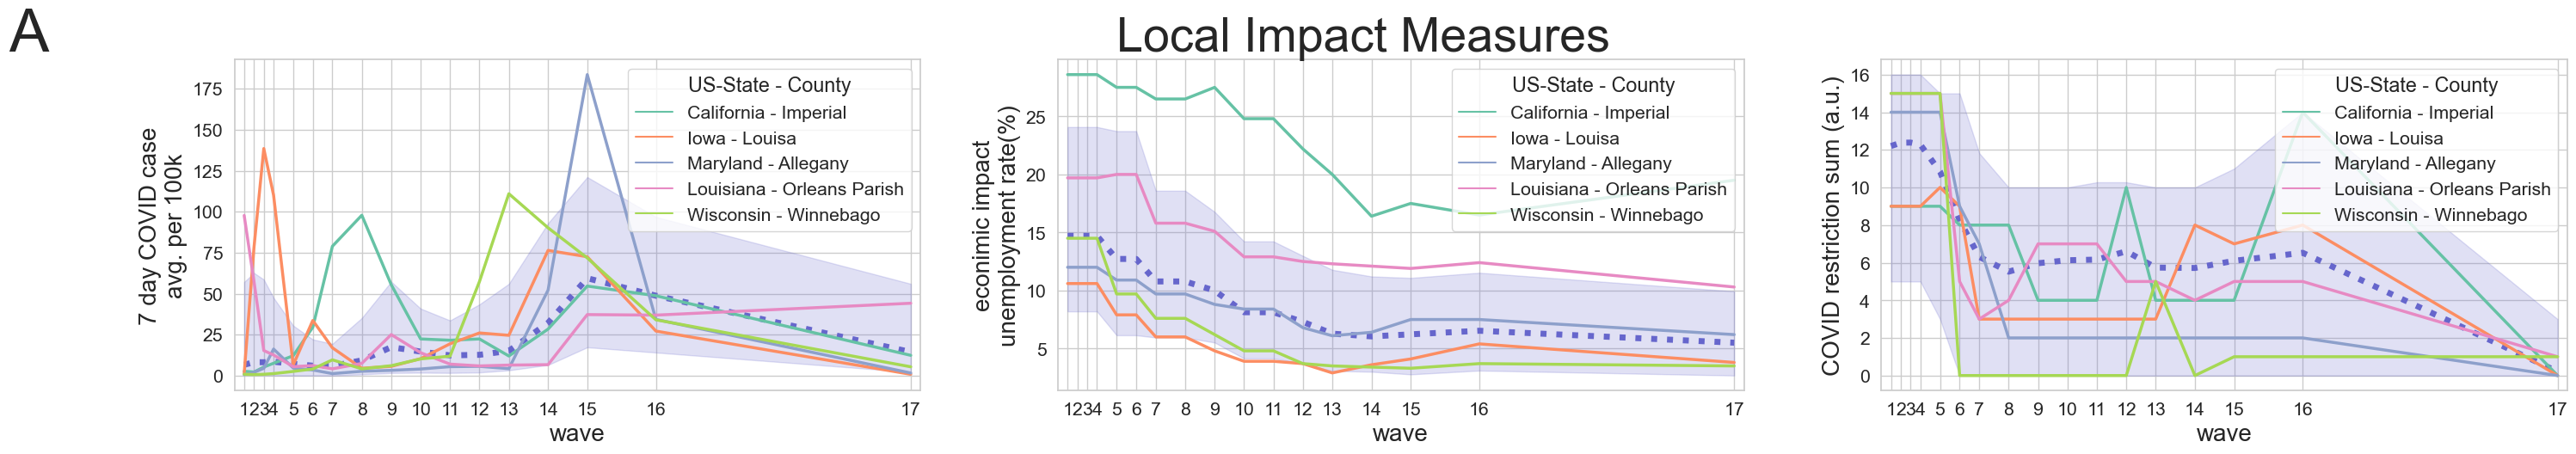

In [5]:
plt.rcParams.update({'font.size': 15}) 
measures = ['cases_avg_per_100k', 'ueRate','restriction_sum']
y_labels = ['7 day COVID case\navg. per 100k',
            'econimic impact\nunemployment rate(%)', 'COVID restriction sum (a.u.)']

fig, ax = plt.subplots(1,3, figsize = (35,5))
fig.suptitle('Local Impact Measures',  fontsize = 40)
fig.text(0.05, 1, 'A', verticalalignment='top', horizontalalignment='left',  fontsize = 50)

for idx,m in enumerate(measures):
    row = int(idx/2)
    col = idx%2
    
    val_var = m
    
    county_maxVar = county_data[['state_county', 'week','wave', val_var]].copy()
    county_maxVar = county_maxVar.drop_duplicates(['state_county','week'])
    county_maxVar = county_maxVar.pivot(index = 'state_county', columns = ['week','wave'], values = val_var)
    county_maxVar = county_maxVar.dropna(axis = 0)


    K = 5
    value_array = county_maxVar.values
    id_lables = county_maxVar.index
    if idx==0:
        best_sols_feats, best_sols_labels = max_var_sampling(value_array, id_lables, K)
    most_dist = county_maxVar.loc[best_sols_labels].copy()
    most_dist = most_dist.T
    most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})
    most_dist['state_county'] = most_dist['state_county'].str.replace('_', ' - ')
    most_dist['state_county'] = most_dist['state_county'].str.title()
    most_dist = most_dist.rename(columns = {'state_county': 'US-State - County'})

    sns.set_style("whitegrid")
    all_counties = pd.DataFrame(county_maxVar.T.stack()).reset_index().rename(columns = {0:'value'})
    sns.lineplot(data = all_counties, x = 'week', y = 'value', color=[0.4,0.4,0.8], linewidth=5, linestyle = ':', ax = ax[idx], errorbar=('pi'))
    sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='US-State - County', ax = ax[idx], linewidth=2.5,palette = "Set2")
    ax[idx].set_ylabel(y_labels[idx], fontsize = 20);
    ax[idx].set_xticks(most_dist.week.unique());
    ax[idx].set_xticklabels(most_dist.wave.unique());
    ax[idx].set_xlabel('wave', fontsize = 20);


    ax[idx].set_xlim(0,70)
    img_format = 'svg'
    fig.savefig(os.path.join(fig_dir, 'timecourse_external_measure.' + img_format), format=img_format)
    
    

In [6]:
county_data_keyMeasures = county_data[['PROLIFIC_PID', 'wave', 'week', 
                                      'state', 'county', 'loc_description', 'flag',
                                      'cases_avg_per_100k', 'deaths_avg_per_100k', 
                                      'raci_event_count', 'ueRate','restriction_sum']].copy()
county_data_keyMeasures.to_csv(os.path.join(out_dir,'externalKeyMeasures_county.csv'))

national_data.to_csv(os.path.join(out_dir,'externalKeyMeasures_national.csv'))


In [7]:
national_data

,wave,week,cases_avg_per_100k_nat,ueRate_nat,restriction_sum_nat
0,1,1,6.2028,13.300,12.240000
1,2,2,7.5726,13.300,12.500000
2,3,3,7.4536,13.300,12.502828
3,4,4,8.3212,13.300,12.282828
4,5,6,7.6530,11.898,10.185077
5,6,8,6.8532,11.898,7.597926
6,7,10,6.0260,10.118,6.084607
7,8,13,8.9184,10.118,5.137890
8,9,16,15.9268,9.292,5.313378
9,10,19,14.4862,7.486,5.460241
